In [30]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

Использование: python script_name.py <путь_к_изображению_с_колорчекером>


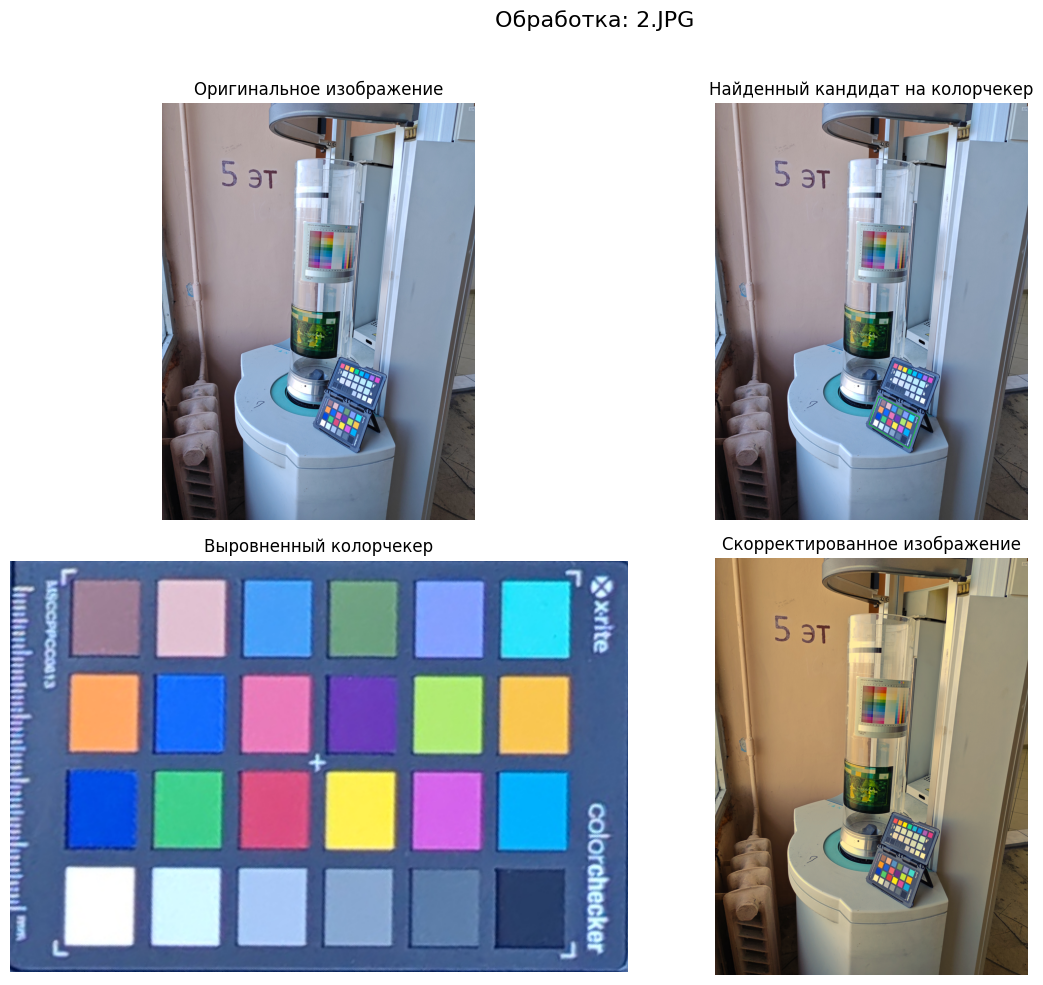

In [54]:
# --- Конфигурация и эталонные данные ---
REFERENCE_COLORCHECKER_RGB = np.array([
    # Формат: [R, G, B]
    # Ряд 1
    [115, 82, 68],   # Темная кожа
    [194, 150, 130], # Светлая кожа
    [98, 122, 157],  # Голубое небо
    [87, 108, 67],   # Листва
    [133, 128, 177], # Голубой цветок
    [103, 189, 170], # Голубовато-зеленый
    # Ряд 2
    [214, 126, 44],  # Оранжевый
    [80, 91, 166],   # Пурпурно-синий
    [193, 90, 99],   # Умеренно-красный
    [94, 60, 108],   # Фиолетовый
    [157, 188, 64],  # Желто-зеленый
    [224, 163, 46],  # Оранжево-желтый
    # Ряд 3
    [56, 61, 150],   # Синий
    [70, 148, 73],   # Зеленый
    [175, 54, 60],   # Красный
    [231, 199, 31],  # Желтый
    [187, 86, 149],  # Маджента
    [8, 133, 161],   # Циан
    # Ряд 4 (шкала серого)
    [243, 243, 242], # Белый
    [200, 200, 200], # Нейтральный 8
    [160, 160, 160], # Нейтральный 6.5
    [122, 122, 121], # Нейтральный 5
    [85, 85, 85],    # Нейтральный 3.5
    [52, 52, 52]     # Черный
], dtype=np.float32)

TARGET_WARPED_WIDTH = 600  # Ширина выровненного колорчекера
TARGET_WARPED_HEIGHT = 400 # Высота выровненного колорчекера
PATCH_ROWS = 4
PATCH_COLS = 6

def get_reference_colors_bgr():
    """Возвращает эталонные цвета в формате BGR."""
    return REFERENCE_COLORCHECKER_RGB[:, ::-1] # Конвертация RGB -> BGR

def order_points(pts):
    """
    Упорядочивает 4 точки контура: верхняя-левая, верхняя-правая,
    нижняя-правая, нижняя-левая.
    Использует метод, основанный на суммах и разностях координат.
    """
    rect = np.zeros((4, 2), dtype="float32")

    # Верхняя-левая точка имеет наименьшую сумму (x+y)
    # Нижняя-правая точка имеет наибольшую сумму (x+y)
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]

    # Верхняя-правая точка имеет наименьшую разность (y-x)
    # Нижняя-левая точка имеет наибольшую разность (y-x)
    # diff = np.diff(pts, axis=1) # Это y_coord - x_coord для каждой точки
    # Примечание: np.diff(pts, axis=1) вычисляет pts[:, 1] - pts[:, 0]
    diff = pts[:, 1] - pts[:, 0] # Явно вычисляем y - x
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    
    return rect

def find_color_checker_candidate(image, min_area_ratio=0.005, max_area_ratio=0.5):
    """
    Находит наиболее вероятный кандидат на колорчекер.
    Возвращает контур (4 точки) или None.
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    # denoised = cv2.fastNlMeansDenoising(blurred, h=20, templateWindowSize=21, searchWindowSize=21)
    # equalized = cv2.equalizeHist(denoised)
    cv2.imwrite("blurred.jpg", blurred)


    # Адаптивное пороговое значение может быть лучше в некоторых случаях
    # edged = cv2.adaptiveThreshold(equalized, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
    #                               cv2.THRESH_BINARY_INV, 11, 2)
    edged = cv2.Canny(blurred, 30, 100) # Пороги могут требовать подстройки
    cv2.imwrite("edged.jpg", edged)
    contours, _ = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if not contours:
        return None

    # contours = sorted(contours, key=cv2.contourArea, reverse=True)[:20] # Рассматриваем топ-20 контуров
    cntimg = image.copy()
    cv2.drawContours(cntimg, contours, -1, (0, 255, 0), 4)
    cv2.imwrite('cnt.jpg', cntimg)

    img_area = image.shape[0] * image.shape[1]
    min_area = img_area * min_area_ratio
    max_area = img_area * max_area_ratio

    for c in contours:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.025 * peri, True) # Эпсилон может требовать подстройки

        if len(approx) == 4:
            contour_area = cv2.contourArea(approx)
            if not (min_area < contour_area < max_area):
                continue

            # Проверка соотношения сторон ограничивающего прямоугольника
            (x, y, w, h) = cv2.boundingRect(approx)
            aspect_ratio = w / float(h) if h > 0 else 0
            if not (0.5 < aspect_ratio < 2.5): # Ожидаем что-то похожее на 3:2 или 2:3
                 # Для большей устойчивости можно использовать minAreaRect
                rect_min_area = cv2.minAreaRect(approx)
                (w_ma, h_ma) = rect_min_area[1]
                if w_ma > 0 and h_ma > 0:
                    aspect_ratio_ma = max(w_ma,h_ma) / min(w_ma,h_ma)
                    if not (1.0 < aspect_ratio_ma < 2.0): # Более строгий для ColorChecker (обычно ~1.5)
                        continue
                else:
                    continue

            return approx.reshape(4, 2)
            
    return None


def extract_patch_colors(warped_checker_image, rows=PATCH_ROWS, cols=PATCH_COLS):
    """
    Извлекает средние цвета из каждого патча на выровненном изображении колорчекера.
    Изображение должно быть в BGR.
    """
    h, w, _ = warped_checker_image.shape
    patch_h = h // rows
    patch_w = w // cols
    
    measured_colors_bgr = []
    
    margin_x = patch_w // 5 # Отступ от краев патча для усреднения
    margin_y = patch_h // 5
    
    for r_idx in range(rows):
        for c_idx in range(cols):
            y_start = r_idx * patch_h + margin_y
            y_end = (r_idx + 1) * patch_h - margin_y
            x_start = c_idx * patch_w + margin_x
            x_end = (c_idx + 1) * patch_w - margin_x
            
            patch = warped_checker_image[y_start:y_end, x_start:x_end]
            
            if patch.size == 0:
                # Если патч пустой (например, из-за округления или слишком больших отступов)
                # Берем центральный пиксель или небольшую область вокруг него
                center_y = r_idx * patch_h + patch_h // 2
                center_x = c_idx * patch_w + patch_w // 2
                # Убедимся, что не выходим за границы
                center_y = np.clip(center_y, 0, h - 1)
                center_x = np.clip(center_x, 0, w - 1)
                
                # Берем небольшое окно 3x3, если возможно
                patch_sample = warped_checker_image[max(0, center_y-1):min(h, center_y+2), 
                                                    max(0, center_x-1):min(w, center_x+2)]
                if patch_sample.size > 0:
                    avg_color = np.mean(patch_sample, axis=(0, 1))
                else: # Крайний случай, если даже 1 пиксель взять не удалось
                    avg_color = np.array([0,0,0], dtype=np.float32) # Возвращаем черный
            else:
                avg_color = np.mean(patch, axis=(0, 1))
            measured_colors_bgr.append(avg_color)
            
    return np.array(measured_colors_bgr, dtype=np.float32)


def calculate_color_correction_matrix(measured_colors, reference_colors):
    """
    Рассчитывает матрицу цветокоррекции T (3x3) так, что:
    reference_colors = measured_colors @ T
    measured_colors: (N, 3) - измеренные цвета
    reference_colors: (N, 3) - эталонные цвета
    """
    if measured_colors.shape[0] != reference_colors.shape[0]:
        raise ValueError("Количество измеренных и эталонных цветов должно совпадать.")
    if measured_colors.shape[0] < 3: # Нужно хотя бы 3 точки для матрицы 3x3
        raise ValueError("Недостаточно цветовых патчей для определения преобразования.")

    # Решаем систему линейных уравнений Ax = B, где x - это наша матрица T
    # measured @ T = reference  => T = pinv(measured) @ reference
    T, _, _, _ = np.linalg.lstsq(measured_colors, reference_colors, rcond=None)
    return T


def apply_color_correction(image_bgr, transform_matrix):
    """
    Применяет матрицу цветокоррекции к изображению.
    image_bgr: исходное изображение в BGR.
    transform_matrix: матрица T (3x3).
    """
    original_shape = image_bgr.shape
    # Преобразуем пиксели в (N, 3) и тип float32 для вычислений
    pixels = image_bgr.reshape(-1, 3).astype(np.float32)
    
    # Применяем преобразование: corrected_pixel = original_pixel @ transform_matrix
    corrected_pixels = pixels @ transform_matrix
    
    # Ограничиваем значения диапазоном [0, 255] и конвертируем обратно в uint8
    corrected_pixels = np.clip(corrected_pixels, 0, 255)
    corrected_image_bgr = corrected_pixels.reshape(original_shape).astype(np.uint8)
    
    return corrected_image_bgr


def process_image_file(image_path):
    """
    Полный цикл обработки одного изображения.
    """
    img_bgr = cv2.imread(image_path)
    if img_bgr is None:
        print(f"Ошибка: не удалось загрузить изображение {image_path}")
        return None, None, None, None
    
    original_img_rgb_display = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) # Для отображения в Matplotlib

    # 1. Поиск кандидата на колорчекер
    quad_candidate_points = find_color_checker_candidate(img_bgr.copy())
    
    img_with_contour_display = original_img_rgb_display.copy() # Для отображения контура
    
    if quad_candidate_points is None:
        print(f"Кандидат на колорчекер не найден в {image_path}.")
        return original_img_rgb_display, None, img_with_contour_display, None

    # Отображение найденного контура (зеленым цветом)
    cv2.drawContours(img_with_contour_display, [quad_candidate_points.astype(int)], -1, (0, 255, 0), 3)
    # Конвертация в RGB для Matplotlib
    img_with_contour_display = cv2.cvtColor(cv2.cvtColor(img_with_contour_display, cv2.COLOR_RGB2BGR), cv2.COLOR_BGR2RGB)


    # 2. Упорядочивание точек и перспективное преобразование
    ordered_quad_src_pts = order_points(quad_candidate_points.astype(np.float32))
    
    dst_pts = np.array([
        [0, 0], # Верхний-левый
        [TARGET_WARPED_WIDTH - 1, 0], # Верхний-правый
        [TARGET_WARPED_WIDTH - 1, TARGET_WARPED_HEIGHT - 1], # Нижний-правый
        [0, TARGET_WARPED_HEIGHT - 1]  # Нижний-левый
    ], dtype="float32")
    
    perspective_matrix = cv2.getPerspectiveTransform(ordered_quad_src_pts, dst_pts)
    warped_checker_bgr = cv2.warpPerspective(img_bgr, perspective_matrix, (TARGET_WARPED_WIDTH, TARGET_WARPED_HEIGHT))
    
    if warped_checker_bgr is None or warped_checker_bgr.size == 0:
        print(f"Ошибка при выравнивании колорчекера в {image_path}.")
        return original_img_rgb_display, None, img_with_contour_display, None
    
    warped_checker_rgb_display = cv2.cvtColor(warped_checker_bgr, cv2.COLOR_BGR2RGB)

    # 3. Извлечение цветов патчей
    measured_bgr_patch_colors = extract_patch_colors(warped_checker_bgr)
    
    if len(measured_bgr_patch_colors) != (PATCH_ROWS * PATCH_COLS):
        print(f"Не удалось извлечь {PATCH_ROWS * PATCH_COLS} патчей из {image_path}. Найдено: {len(measured_bgr_patch_colors)}")
        return original_img_rgb_display, None, img_with_contour_display, warped_checker_rgb_display

    # 4. Расчет матрицы цветокоррекции
    reference_bgr_colors = get_reference_colors_bgr()
    try:
        correction_matrix_T = calculate_color_correction_matrix(measured_bgr_patch_colors, reference_bgr_colors)
    except ValueError as e:
        print(f"Ошибка при расчете матрицы коррекции для {image_path}: {e}")
        return original_img_rgb_display, None, img_with_contour_display, warped_checker_rgb_display

    # 5. Применение цветокоррекции
    corrected_img_bgr = apply_color_correction(img_bgr.copy(), correction_matrix_T)
    corrected_img_rgb_display = cv2.cvtColor(corrected_img_bgr, cv2.COLOR_BGR2RGB)
    
    return original_img_rgb_display, corrected_img_rgb_display, img_with_contour_display, warped_checker_rgb_display

# --- Основная часть для запуска ---
if __name__ == '__main__':
    print("Использование: python script_name.py <путь_к_изображению_с_колорчекером>")
    
    
    image_file_path = "images/2.JPG"

    results = process_image_file(image_file_path)

    if results and results[0] is not None:
        original_rgb, corrected_rgb, img_with_contour_rgb, warped_rgb = results
        
        fig, axes = plt.subplots(2, 2, figsize=(12, 10))
        fig.suptitle(f"Обработка: {image_file_path.split('/')[-1]}", fontsize=16)

        axes[0, 0].imshow(original_rgb)
        axes[0, 0].set_title("Оригинальное изображение")
        axes[0, 0].axis('off')
        
        axes[0, 1].imshow(img_with_contour_rgb)
        axes[0, 1].set_title("Найденный кандидат на колорчекер")
        axes[0, 1].axis('off')
        
        if warped_rgb is not None:
            axes[1, 0].imshow(warped_rgb)
            axes[1, 0].set_title("Выровненный колорчекер")
            axes[1, 0].axis('off')
        else:
            axes[1, 0].text(0.5, 0.5, 'Выравнивание не удалось\nили не требуется', ha='center', va='center', transform=axes[1,0].transAxes)
            axes[1, 0].axis('off')

        if corrected_rgb is not None:
            axes[1, 1].imshow(corrected_rgb)
            axes[1, 1].set_title("Скорректированное изображение")
            axes[1, 1].axis('off')
        else:
            axes[1, 1].text(0.5, 0.5, 'Коррекция не удалась\nили не требуется', ha='center', va='center', transform=axes[1,1].transAxes)
            axes[1, 1].axis('off')
            
        plt.tight_layout(rect=[0, 0, 1, 0.96]) # Оставляем место для suptitle
        plt.show()
    else:
        print(f"Не удалось обработать изображение {image_file_path}")

